In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import optuna
import joblib
import io
import pickle as pkl
from optuna.samplers import TPESampler
from tensorflow import keras
from keras import optimizers
from keras import Sequential
from keras import layers
from keras import utils, callbacks
from keras.models import Model
from keras.layers import LeakyReLU as lrelu
from keras.layers import ReLU as relu
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, Input, MaxPool2D, Permute, GlobalAveragePooling2D, MaxPooling2D
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.backend import clear_session
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import SparseCategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

In [2]:
# #webcam dataset (grassknot.zip)
# !gdown 1QQozu0ldXuSVNPKjxRVYE6fCjIgdktwn


# # from zipfile import ZipFile
# with ZipFile("grassknot.zip","r") as zipObj:
#     zipObj.extractall()

#fixed hyperparameters
SPLIT_RATIO = (0.75,0.15,0.10)
IMG_TARGET_SIZE = (64,64)
EPOCHS = 30
NUM_CLASSES = 26

#tuning
#data_batch_size = 32,64,128
#cnn_layers = 3,4,5,6,7,8
#learning_rate = between 0.01 and 0.00001
#activation_fn = 'relu, leaky relu, relu6'

# #split dataset into train, val, test
# import splitfolders
# splitfolders.ratio("./grassknot/", output="./data/",
#     seed=42, ratio=SPLIT_RATIO, group_prefix=None, move=False)



In [3]:
def train_results(history,trial_no):
  
  fig_path = './project/'+'trial'+str(trial_no)+'.jpg'
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(loc='lower right')
  plt.title('Accuracy Curve')

  plt.subplot(2,1,2)
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim([0, 10])
  plt.legend(loc='upper right')
  plt.title('Loss Curve')
  
  plt.rcParams["figure.figsize"] = (10,10)
  plt.tight_layout()
  plt.rcParams['savefig.orientation'] = 'landscape'
  #plt.savefig(fig_path)
  plt.show()

In [4]:
def test_results(test,y_vals):
    classes = list(test.class_indices.keys())
    cm = confusion_matrix(test.classes,y_vals)
    disp = ConfusionMatrixDisplay(cm, display_labels = classes)
    plt.rcParams["figure.figsize"] = (15,10)
    disp.plot(cmap=plt.cm.Blues)
    plt.tight_layout()
    #plt.savefig('./project/results/hyperparameter_optimization/trial_results/'+'confusion_matrix.jpg')
    plt.show()
    print(classification_report(test.classes, y_vals, target_names=classes))

In [5]:
def check_distribution(train,val):
    pass


In [8]:
def hpo(trial):
    
    clear_session()
    
    global train,val,test,pred_vals,history,model
    
    gen_aug = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=15) 
    gen = ImageDataGenerator(rescale=1./255) 
    trial_no = trial.number
    
    #defining the hyperparameters that need tuning
    batch_size = trial.suggest_categorical('batch_size',[105])
    num_layers = trial.suggest_categorical('num_layers', [4])
    activation = trial.suggest_categorical('activation',['elu'])
    learning_rate = trial.suggest_categorical("learning_rate",[0.001698893])
    
    ##image directories - loading data
    train = gen_aug.flow_from_directory("./data/train",
                                target_size=IMG_TARGET_SIZE,
                                batch_size=batch_size, shuffle=True)

    val = gen.flow_from_directory("./data/val",
                              target_size=IMG_TARGET_SIZE,
                              batch_size=batch_size, shuffle=False)

    test = gen.flow_from_directory("./data/test", 
                               target_size=IMG_TARGET_SIZE, 
                               class_mode=None, shuffle=False)
    
    check_distribution(train,val)
    
    model_name = ('model_'+str(trial_no))
    ##creating the model architecture
    model = Sequential(name=model_name)
    num_filters = [64, 128, 128, 128, 256, 256, 512, 512]

    for layer in range(num_layers):
        model.add(Conv2D(filters = num_filters[layer], kernel_size = 5, padding = 'same', activation = activation))
        if layer != num_layers:
            model.add(MaxPooling2D())
            model.add(BatchNormalization())
            model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    #compile the model
    model.compile(loss=CategoricalCrossentropy(),
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    
    #callback functions
    early_stopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)
    
    #train the model and save it
    history = model.fit(x=train, validation_data = val, epochs=30, shuffle = True, verbose = 1, callbacks=[early_stopping])
    train_results(history,trial_no)
    model.save("model_"+str(trial_no))
    
    #run the model on the test data and get test accuracy
    pred = model.predict(test, batch_size=(test.samples//test.batch_size+1))
    pred_vals = np.argmax(pred, axis=1)
    score = accuracy_score(test.classes,pred_vals)
    return score

[I 2022-08-22 13:15:51,548] A new study created in memory with name: no-name-1c3ffacf-2f2a-4373-a9da-7790dbbb58af


Found 58500 images belonging to 26 classes.
Found 11700 images belonging to 26 classes.
Found 7826 images belonging to 26 classes.
Epoch 1/30
558/558 [==============================] - 81s 144ms/step - loss: 2.3296 - accuracy: 0.3496 - val_loss: 3.0602 - val_accuracy: 0.3493
Epoch 2/30
558/558 [==============================] - 83s 148ms/step - loss: 0.8706 - accuracy: 0.7084 - val_loss: 2.6147 - val_accuracy: 0.5244
Epoch 3/30
558/558 [==============================] - 82s 147ms/step - loss: 0.4396 - accuracy: 0.8473 - val_loss: 0.2134 - val_accuracy: 0.9250
Epoch 4/30
558/558 [==============================] - 84s 150ms/step - loss: 0.2990 - accuracy: 0.8976 - val_loss: 0.3821 - val_accuracy: 0.8810
Epoch 5/30
558/558 [==============================] - 86s 154ms/step - loss: 0.2274 - accuracy: 0.9204 - val_loss: 0.1892 - val_accuracy: 0.9324
Epoch 6/30
558/558 [==============================] - 85s 152ms/step - loss: 0.1873 - accuracy: 0.9352 - val_loss: 0.4085 - val_accuracy: 0.8862

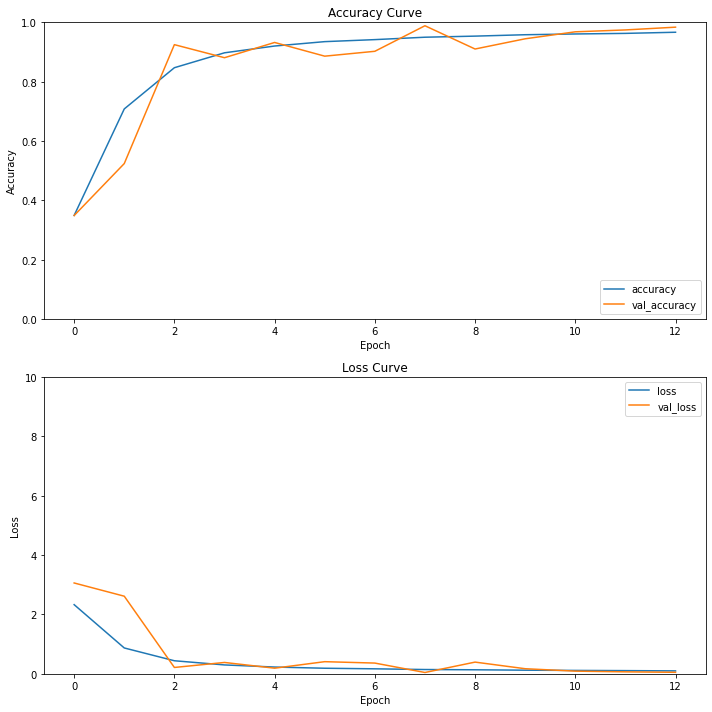

INFO:tensorflow:Assets written to: model_0\assets


INFO:tensorflow:Assets written to: model_0\assets


245/245 [==============================] - 9s 37ms/step


[I 2022-08-22 13:34:26,370] Trial 0 finished with value: 0.9872220802453361 and parameters: {'batch_size': 105, 'num_layers': 4, 'activation': 'elu', 'learning_rate': 0.001698893}. Best is trial 0 with value: 0.9872220802453361.


Found 58500 images belonging to 26 classes.
Found 11700 images belonging to 26 classes.
Found 7826 images belonging to 26 classes.
Epoch 1/30
558/558 [==============================] - 86s 153ms/step - loss: 2.2580 - accuracy: 0.3685 - val_loss: 1.2346 - val_accuracy: 0.5891
Epoch 2/30
558/558 [==============================] - 86s 154ms/step - loss: 0.8115 - accuracy: 0.7278 - val_loss: 0.6299 - val_accuracy: 0.7773
Epoch 3/30
558/558 [==============================] - 87s 155ms/step - loss: 0.4359 - accuracy: 0.8495 - val_loss: 0.3283 - val_accuracy: 0.9005
Epoch 4/30
558/558 [==============================] - 85s 153ms/step - loss: 0.2840 - accuracy: 0.9006 - val_loss: 0.3229 - val_accuracy: 0.8945
Epoch 5/30
558/558 [==============================] - 87s 156ms/step - loss: 0.2168 - accuracy: 0.9244 - val_loss: 0.0617 - val_accuracy: 0.9813
Epoch 6/30
558/558 [==============================] - 87s 156ms/step - loss: 0.1801 - accuracy: 0.9376 - val_loss: 0.4484 - val_accuracy: 0.9056

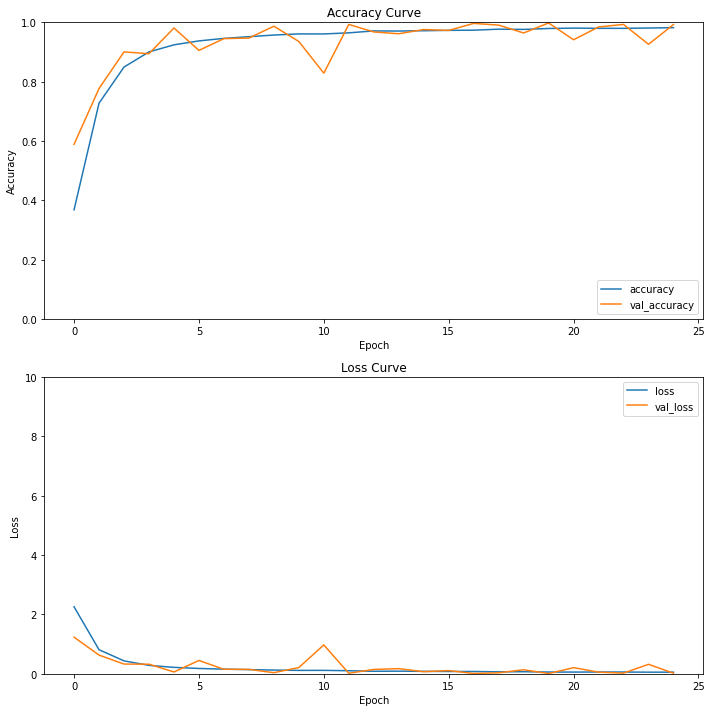

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


245/245 [==============================] - 9s 35ms/step


[I 2022-08-22 14:12:58,529] Trial 1 finished with value: 0.9969332992588806 and parameters: {'batch_size': 105, 'num_layers': 4, 'activation': 'elu', 'learning_rate': 0.001698893}. Best is trial 1 with value: 0.9969332992588806.


Number of finished trials: 2
Best trial:
  Value: 0.9969332992588806
  Params: 
    batch_size: 105
    num_layers: 4
    activation: elu
    learning_rate: 0.001698893


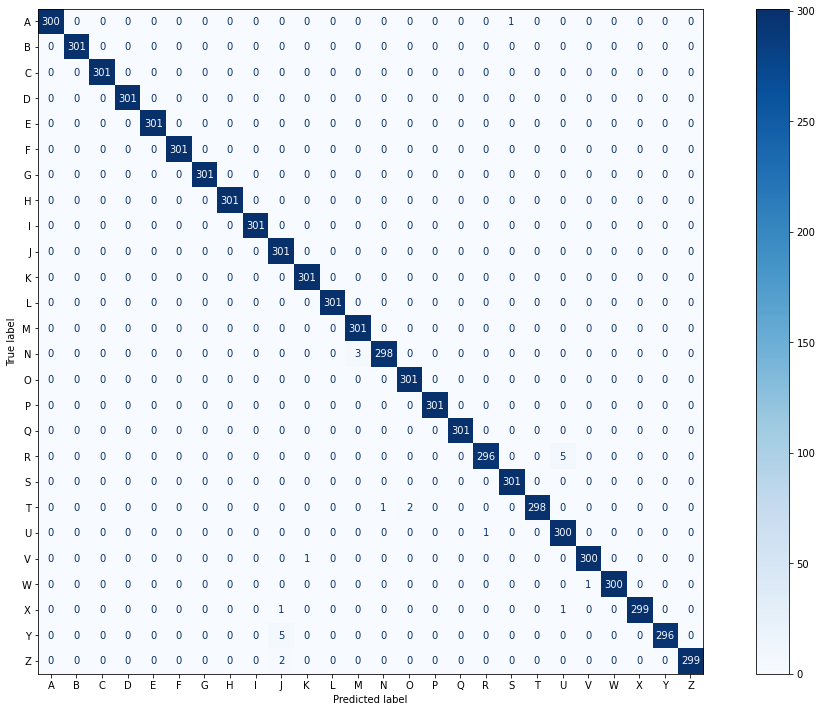

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       301
           B       1.00      1.00      1.00       301
           C       1.00      1.00      1.00       301
           D       1.00      1.00      1.00       301
           E       1.00      1.00      1.00       301
           F       1.00      1.00      1.00       301
           G       1.00      1.00      1.00       301
           H       1.00      1.00      1.00       301
           I       1.00      1.00      1.00       301
           J       0.97      1.00      0.99       301
           K       1.00      1.00      1.00       301
           L       1.00      1.00      1.00       301
           M       0.99      1.00      1.00       301
           N       1.00      0.99      0.99       301
           O       0.99      1.00      1.00       301
           P       1.00      1.00      1.00       301
           Q       1.00      1.00      1.00       301
           R       1.00    

In [9]:
#hpo - run the trials
clear_session()
sampler = TPESampler(seed=123)  # Make the sampler behave in a deterministic way and get reproducable results
study = optuna.create_study(direction="maximize",sampler=sampler)
study.optimize(hpo, n_trials=2)
#joblib.dump(study,'./project/results/hyperparameter_optimization/trial_results/study.pkl',)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
best_model = study.best_trial

print("  Value: {}".format(best_model.value))

print("  Params: ")
for key, value in best_model.params.items():
    print("    {}: {}".format(key, value))
    
test_results(test,pred_vals)

In [21]:
keras.models.load_model("./project/results/best_model/best_model")

In [ ]:
#get the trials data
study_file = open("./project/results/hyperparameter_optimization/trials_data/study.pkl","rb")
final_study = joblib.load(study_file)


In [ ]:
#get trials as csv
study_data = pd.DataFrame(final_study.trials_dataframe())
data_csv = study_data.to_csv("./project/results/hyperparameter_optimization/trial_studies/study.csv")